# Autoencoders
# Notes

Simply put, autoencoders are neural networks that learn a compressed representation of their input data. They are trained to reproduce their input data, and are a type of unsupervised learning algorithm.

This is really helpful for a number of applications:
- Dimensionality reduction: Autoencoders can be used to reduce the dimensionality of a dataset, which can be useful for data visualization and for speeding up machine learning algorithms.
- Denoising: Autoencoders can be used to denoise data, which can be useful for image processing and other applications.
- Compression: Autoencoders can be used to compress data, which can be useful for data storage and transmission.

## Training the autoencoder to reproduce its input

| The network weights | Loss Function is the differnce between the input and the output | The MSE loss function |
| :---: | :---: | :---: |
| 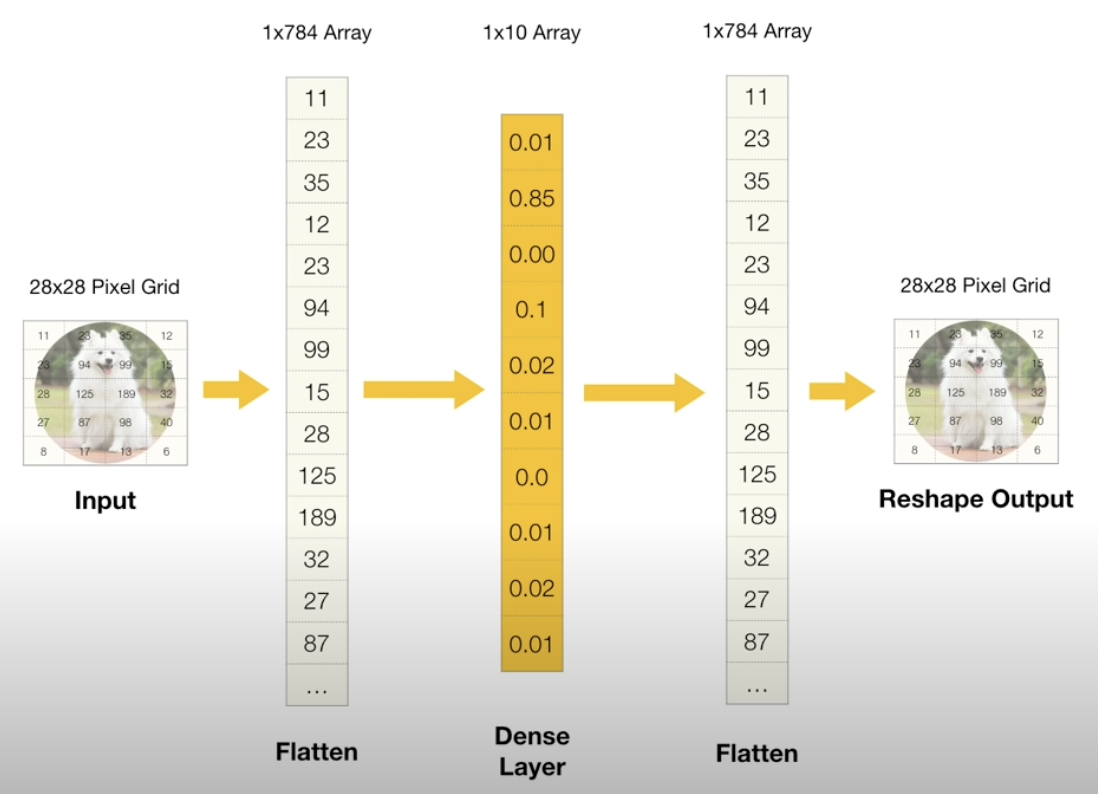 | 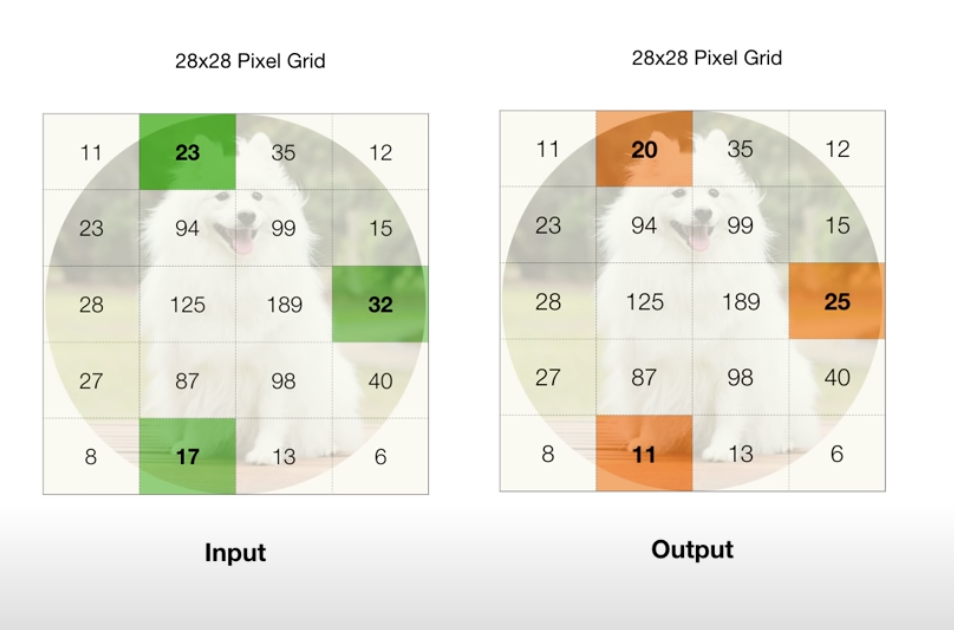 | 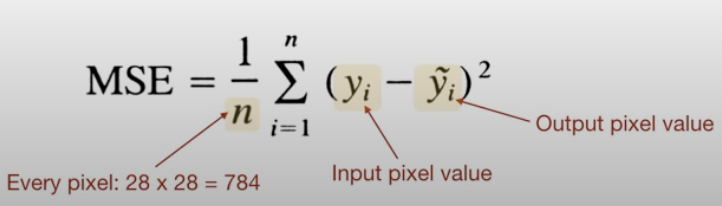 |

## Compression / Decompression

The smaller the hidden layer, the more the network is forced to learn a compressed representation of the input data.

Gradient descent will compress the input data into its smallest possible space.

We can save the image using the weights leading to the hidden layer.
We can decompress and image using the weights leading to the output layer.

| Compression | 
| :---: |
| 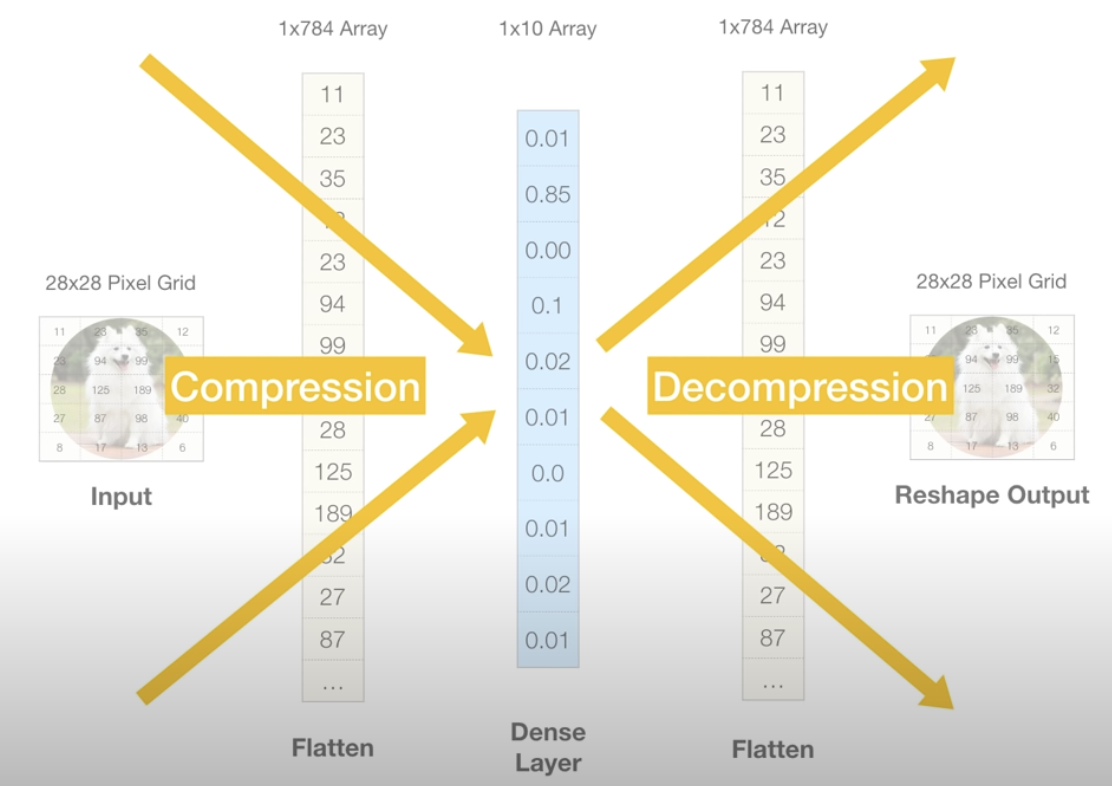 |

## Definitions
- **Encoder**: The encoder is the part of the autoencoder that compresses the input data into a smaller representation.
- **Decoder**: The decoder is the part of the autoencoder that reconstructs the input data from the compressed representation.
- **Free parameters**: The free parameters are the weights and biases of the neural network.
- **Weights**: The weights are the parameters that are learned during training.
- **Biases**: The biases are the parameters that are learned during training.

The difference between weights and biases is that the weights are multiplied by the input data, while the biases are added to the input data.

In the equation $y = wx + b$, the weights are $w$ and the biases are $b$. $x$ is the input data. $y$ is the output data.

A neuron equation is the sum of the inputs multiplied by the weights, plus the bias, expressed by the formula $y = \sum_i w_i x_i + b$.



# The AutoEncoder

## Imports

In [2]:
from keras.layers import Input, Dense, Flatten, Reshape, Conv2D, UpSampling2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.datasets import mnist
from keras.callbacks import Callback
import numpy as np
from dotdict import dotdict as dd


## Setup W&B

In [3]:
import wandb
from wandb.keras import WandbCallback

## Load and Normalise Data

Because Autoencoders are unsupervised learning algorithms, we don't need the labels for this dataset.

In [4]:
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


## Model Config

The encoding dimension is the most important hyperparameter (or variables) in the autoencoder.

In [5]:
config = dd.Dict()
config.encoding_dim = 32
config.epochs = 10


## Build the Model (Without Convolutions)

In [6]:
# model = Sequential()
# model.add(Flatten(input_shape=(28,28)))
# model.add(Dense(config.encoding_dim, activation='relu'))
# model.add(Dense(28*28, activation='sigmoid'))
# model.add(Reshape((28,28)))
# model.compile(optimizer='adam', loss='mse')

## Build the model (with Convolutions)

In [7]:
model = Sequential()
model.add(Reshape((28, 28, 1), input_shape=(28, 28)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))
model.add(Reshape((28, 28)))

model.compile(optimizer='adam', loss='mse')

2023-02-01 12:41:41.635602: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-01 12:41:41.635625: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB



## Check the Model

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 up_sampling2d (UpSampling2D  (None, 28, 28, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         2

## Create Callback for W&B image logging

In [9]:
# For visualization
class Images(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
           
    def on_epoch_end(self, epoch, logs):
        indices = np.random.randint(self.validation_data[0].shape[0], size=8)
        test_data = self.validation_data[0][indices]
        pred_data = self.model.predict(test_data)
        wandb.log({
            "examples": [
                  wandb.Image(np.hstack([data, pred_data[i]]), caption=str(i))
                  for i, data in enumerate(test_data)]},
              step=epoch)


## Train the Model

In [11]:
# Init W&B
run = wandb.init(config=config)

# Train the model
model.fit(x_train, x_train,
          epochs=config.epochs,
          validation_data=(x_test, x_test),
          callbacks=[Images((x_test, x_test)), WandbCallback()])

# Finish the W&B run
run.finish()  

Epoch 1/10
1871/1875 [============================>.] - ETA: 0s - loss: 8.4150e-04

2023-02-01 12:42:41.253571: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 174ms/step


2023-02-01 12:42:43.419627: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 25s 13ms/step - loss: 8.4120e-04 - val_loss: 6.7025e-04
Epoch 2/10
1/1 [==============================] - 0s 13ms/steps - loss: 5.9953e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 23s 12ms/step - loss: 5.9940e-04 - val_loss: 5.3209e-04
Epoch 3/10
1/1 [==============================] - 0s 14ms/steps - loss: 5.0106e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 24s 13ms/step - loss: 5.0106e-04 - val_loss: 4.6769e-04
Epoch 4/10
1/1 [==============================] - 0s 15ms/steps - loss: 4.3692e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 25s 14ms/step - loss: 4.3685e-04 - val_loss: 4.4163e-04
Epoch 5/10
1/1 [==============================] - 0s 14ms/steps - loss: 3.9055e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 25s 13ms/step - loss: 3.9057e-04 - val_loss: 3.9882e-04
Epoch 6/10
1/1 [==============================] - 0s 14ms/steps - loss: 3.5531e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 25s 13ms/step - loss: 3.5528e-04 - val_loss: 3.3504e-04
Epoch 7/10
1/1 [==============================] - 0s 14ms/steps - loss: 3.3142e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 25s 13ms/step - loss: 3.3141e-04 - val_loss: 3.2262e-04
Epoch 8/10
1/1 [==============================] - 0s 14ms/steps - loss: 3.1451e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 26s 14ms/step - loss: 3.1451e-04 - val_loss: 3.0332e-04
Epoch 9/10
1/1 [==============================] - 0s 15ms/steps - loss: 3.0163e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 26s 14ms/step - loss: 3.0164e-04 - val_loss: 2.9116e-04
Epoch 10/10
1/1 [==============================] - 0s 16ms/steps - loss: 2.9182e-


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best/assets
wandb: Adding directory to artifact (/Users/samgreen/Development/ml/wandb/ml-class-notebooks/wandb/run-20230201_124211-rhllsnp3/files/model-best)... Done. 0.0s


1875/1875 [==============================] - 26s 14ms/step - loss: 2.9182e-04 - val_loss: 2.8021e-04


epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▂▂▂▁▁▁
val_loss,█▆▄▄▃▂▂▁▁▁
best_epoch,9
best_val_loss,0.00028
epoch,9
loss,0.00029
val_loss,0.00028


## Results

| No Convolutions |
| :---: |
| 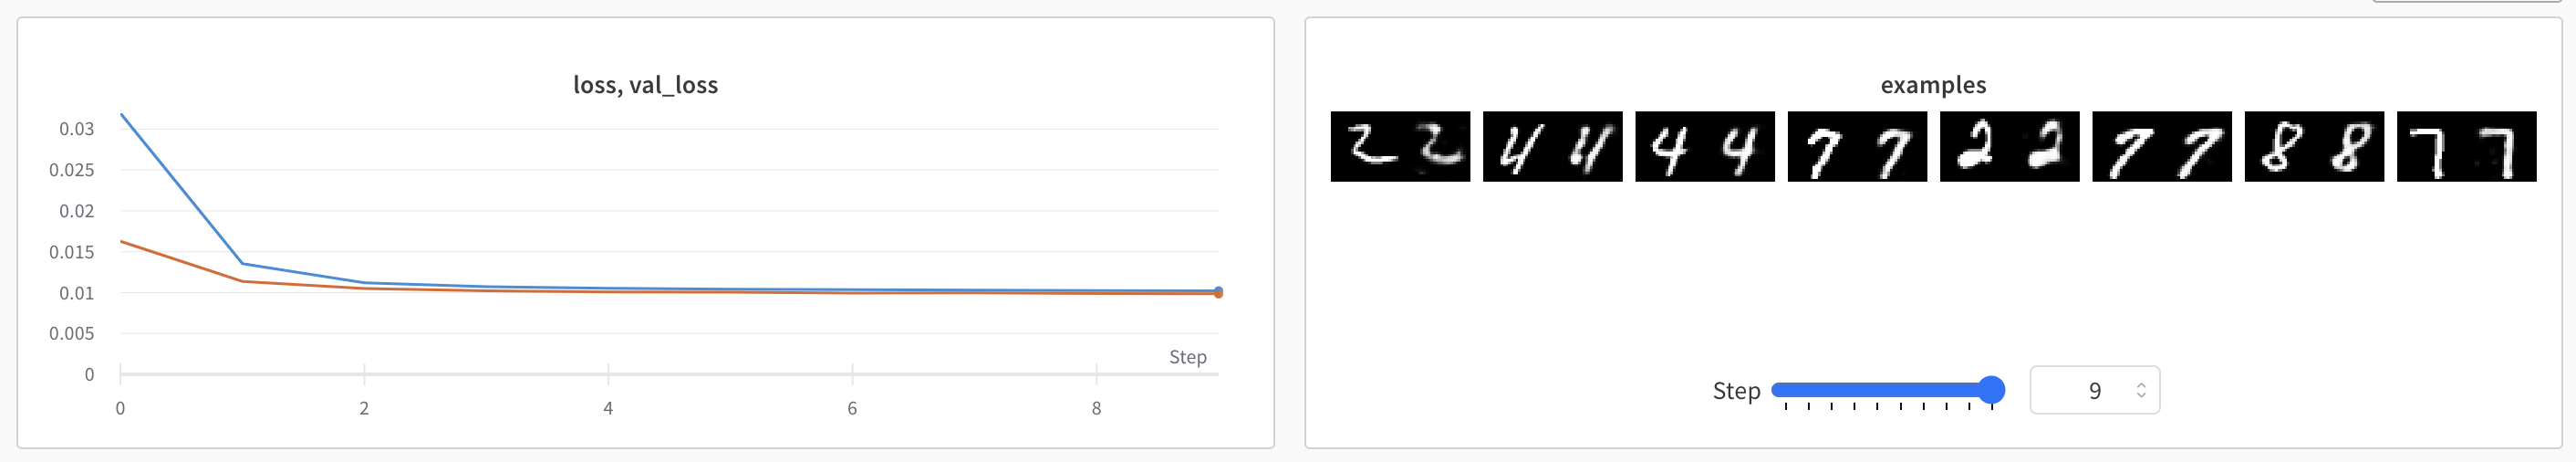 |
| With Convolutions |
| 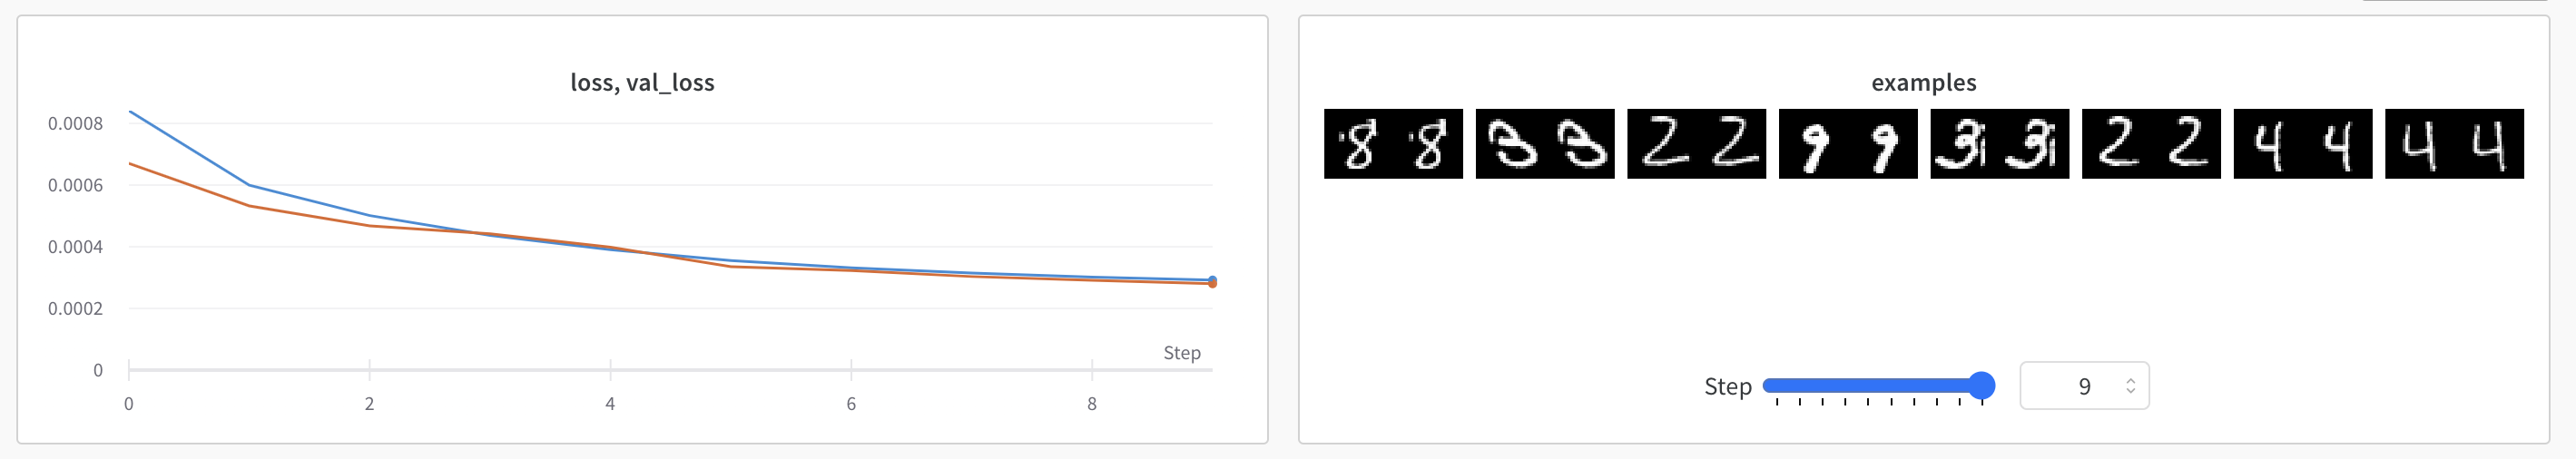 |

## Save the model

In [12]:
model.save('auto-encoder-CNN.h5')